In [1]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import csv
import warnings
import pandas as pd

# Python uyarılarını kapatma
warnings.filterwarnings('ignore')

2024-05-29 18:19:55.741566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 18:19:55.741684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 18:19:56.000057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Csv Dosyası Oluşturma Hard Veri Seti

In [2]:
# Dosyanın var olup olmadığını kontrol edin ve varsa silin
data_csv='/kaggle/working/dataset.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"{data_csv} dosyası silindi.")
else:
    print(f"{data_csv} dosyası bulunamadı.")

data_csv='/kaggle/working/dataset.csv'
data1_dir = '/kaggle/input/fake-vs-real-face-classification/train'
data2_dir = '/kaggle/input/fake-vs-real-face-classification/Validation'

data3_dir = '/kaggle/input/hardfakevsrealfaces'

# CSV dosyasının varlığını kontrol et

if os.path.exists(data_csv):
    print('exists')
else:
    data_dirs = [data3_dir]

    # Define the path for the CSV file
    csv_file = 'dataset.csv'
    data_csv = csv_file

    # Define the class mapping
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
        'training_fake': 'Fake',
        'training_real': 'Real',
        '0': 'Real',
        '1': 'Fake'
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])
                        
    print(f"{csv_file} dosyası oluşturuldu.")

/kaggle/working/dataset.csv dosyası bulunamadı.
dataset.csv dosyası oluşturuldu.


# Veri yükleme

In [3]:
import pandas as pd
# CSV dosyasını oku
data = pd.read_csv(data_csv)

# Resim boyutları
height, width = 224, 224

# Etiketleri değiştirme ve one-hot encoding işlemleri
def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))


# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3), dtype=np.float32)  # Veri tipini float32 olarak ayarladık
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Dosya yolunu al
    img = load_img(img_path, target_size=(height, width))  # Resmi yükle ve boyutlandır
    img_array = np.array(img) / 255.0  # Resmi numpy array'e çevir ve normalize et
    X[i] = img_array  # Array'i X'e ekle

print(X.shape)

(1289, 224, 224, 3)


# Veri setini eğitim,doğrulama ve test verisine bölme

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(902, 224, 224, 3)
(193, 224, 224, 3)
(194, 224, 224, 3)


# Model oluşturma

In [5]:
# InceptionV3 modelini yükleme
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: InceptionV3 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(inceptionv3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model = Model(inceptionv3.input, output)

# Modeli derleme
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Model Eğitimi

In [6]:
# Modelin eğitimi
epochs=10
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val,y_val))

Epoch 1/10


I0000 00:00:1717006927.640829     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717006927.751918     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8389 - loss: 4.8701   

W0000 00:00:1717006987.603112     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717006993.645902     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.8417 - loss: 4.7877 - val_accuracy: 0.4404 - val_loss: 215.9808
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.9499 - loss: 0.1615 - val_accuracy: 0.4404 - val_loss: 225546.9375
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.4508 - val_loss: 15143.3613
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 1.0000 - loss: 1.4111e-04 - val_accuracy: 0.7254 - val_loss: 823.1815
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 1.0000 - loss: 8.8924e-05 - val_accuracy: 0.9534 - val_loss: 76.2157
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 1.0000 - loss: 1.4480e-04 - val_accuracy: 0.9793 - val_loss: 10.2813
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 1.0000 - loss: 9.4625e-06 - val_accuracy: 0.9896 - val_loss: 1.3360
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.9992 - loss: 0.0035

# Sonuçlar

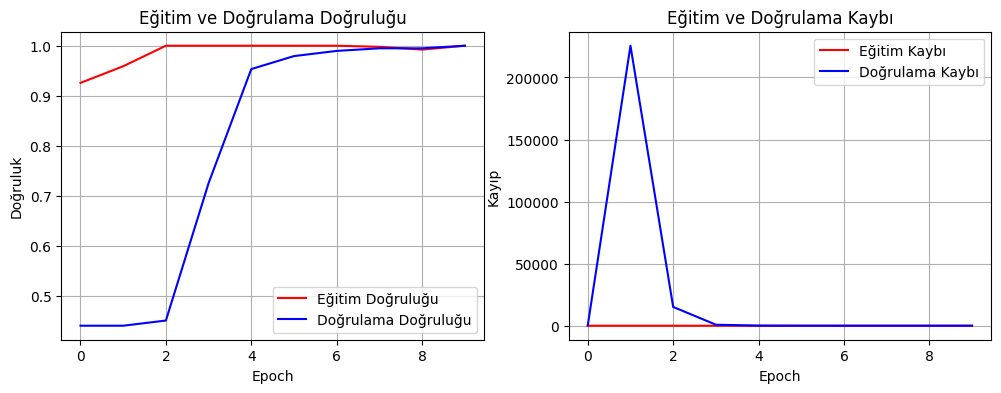

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


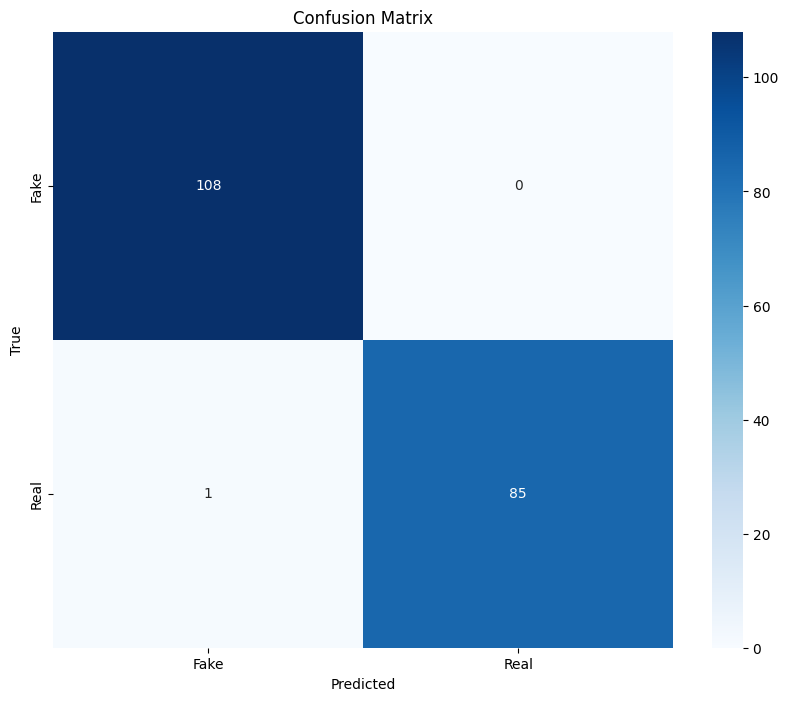

Precision: 0.9949
Recall: 0.9948
F1 Score: 0.9948
Test Accuracy: 0.9948


In [9]:
from sklearn.metrics import confusion_matrix

# Doğruluk ve kayıp grafiği
# Eğitim ve doğrulama doğruluğu ve kaybı grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))


In [ ]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import csv
import warnings
import pandas as pd

# Python uyarılarını kapatma
warnings.filterwarnings('ignore')

# InceptionV3 Farklı bir veri seti üzerinde (Easy)

In [13]:
# Dosyanın var olup olmadığını kontrol edin ve varsa silin
data_csv='/kaggle/working/dataset.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"{data_csv} dosyası silindi.")
else:
    print(f"{data_csv} dosyası bulunamadı.")

data_csv='/kaggle/working/dataset.csv'
data1_dir = '/kaggle/input/fake-vs-real-face-classification/train'
data2_dir = '/kaggle/input/fake-vs-real-face-classification/Validation'

data3_dir = '/kaggle/input/hardfakevsrealfaces'

# CSV dosyasının varlığını kontrol et

if os.path.exists(data_csv):
    print('exists')
else:
    data_dirs = [data1_dir,data2_dir]

    # Define the path for the CSV file
    csv_file = 'dataset.csv'
    data_csv = csv_file

    # Define the class mapping
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
        'training_fake': 'Fake',
        'training_real': 'Real',
        '0': 'Real',
        '1': 'Fake'
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])
                        
    print(f"{csv_file} dosyası oluşturuldu.")

/kaggle/working/dataset.csv dosyası silindi.
dataset.csv dosyası oluşturuldu.


In [14]:
import pandas as pd
# CSV dosyasını oku
data = pd.read_csv(data_csv)

# Resim boyutları
height, width = 224, 224

# Etiketleri değiştirme ve one-hot encoding işlemleri
def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))


# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3), dtype=np.float32)  # Veri tipini float32 olarak ayarladık
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Dosya yolunu al
    img = load_img(img_path, target_size=(height, width))  # Resmi yükle ve boyutlandır
    img_array = np.array(img) / 255.0  # Resmi numpy array'e çevir ve normalize et
    X[i] = img_array  # Array'i X'e ekle

print(X.shape)

(1709, 224, 224, 3)


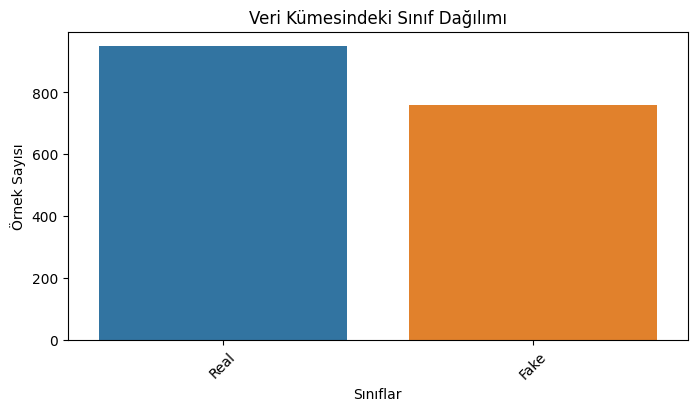

In [15]:
# Veri setindeki sınıf dağılımını görselleştirme
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.title('Veri Kümesindeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1196, 224, 224, 3)
(256, 224, 224, 3)
(257, 224, 224, 3)


In [17]:
tf.keras.backend.clear_session()
# InceptionV3 modelini yükleme
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: InceptionV3 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(inceptionv3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model = Model(inceptionv3.input, output)

# Modeli derleme
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [18]:
epochs = 30
# Modelin eğitimi
history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

Epoch 1/30


W0000 00:00:1717014336.896763     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5236 - loss: 7.4297   

W0000 00:00:1717014401.502162     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717014407.528347     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.5236 - loss: 7.3235 - val_accuracy: 0.5508 - val_loss: 485.4921
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.5230 - loss: 0.7629 - val_accuracy: 0.4648 - val_loss: 141.2014
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.5374 - loss: 0.7029 - val_accuracy: 0.5508 - val_loss: 1.5709
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.4916 - loss: 0.6935 - val_accuracy: 0.5508 - val_loss: 1.6395
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.5347 - loss: 0.6944 - val_accuracy: 0.5430 - val_loss: 0.6885
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.5441 - loss: 0.6916 - val_accuracy: 0.5547 - val_loss: 0.6880
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5408 - loss: 0.6926 - val_accuracy: 0.5547 - val_loss: 0.6929
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.5601 - loss: 0.6854 - val_accuracy: 0.5508 -

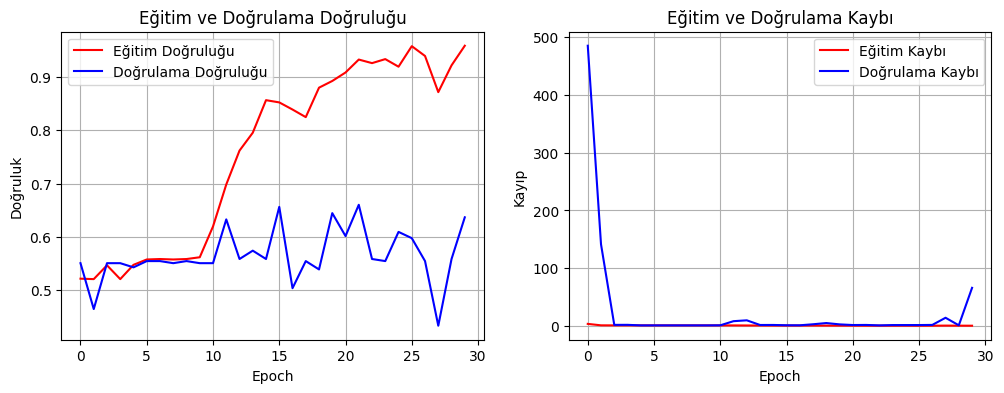

3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

W0000 00:00:1717014788.948689     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


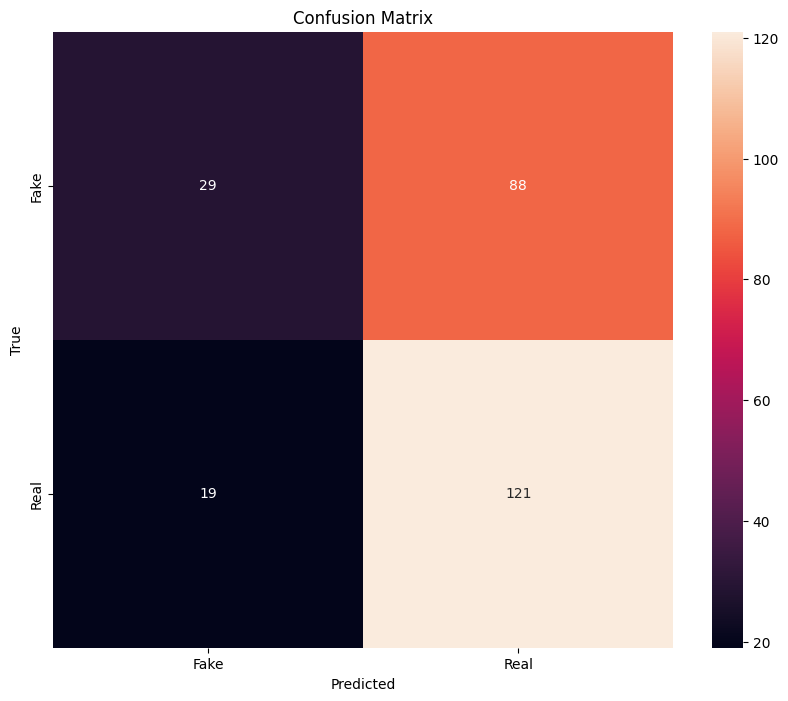

Precision: 0.5904
Recall: 0.5837
F1 Score: 0.5378
Test Accuracy: 0.5837


In [19]:
from sklearn.metrics import confusion_matrix

# Doğruluk ve kayıp grafiği
# Eğitim ve doğrulama doğruluğu ve kaybı grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))


### Buradan Easy veri setinin çok kötü olduğunu görüyoruz. Easy veri setimiz oldukça bozuk bir veri setidir.

# InceptionV3 Veri setleri karıştırılmış halde
### Kullandığımız easy ve hard veri setlerini karıştırıp model üzerindeki performansına bakıyoruz

In [2]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import csv
import warnings
import pandas as pd

# Python uyarılarını kapatma
warnings.filterwarnings('ignore')

2024-05-29 20:07:45.542902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 20:07:45.542999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 20:07:45.678479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Dosyanın var olup olmadığını kontrol edin ve varsa silin
data_csv='/kaggle/working/dataset.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"{data_csv} dosyası silindi.")
else:
    print(f"{data_csv} dosyası bulunamadı.")

data_csv='/kaggle/working/dataset.csv'
data1_dir = '/kaggle/input/fake-vs-real-face-classification/train'
data2_dir = '/kaggle/input/fake-vs-real-face-classification/Validation'

data3_dir = '/kaggle/input/hardfakevsrealfaces'

# CSV dosyasının varlığını kontrol et

if os.path.exists(data_csv):
    print('exists')
else:
    data_dirs = [data1_dir,data2_dir,data3_dir]

    # Define the path for the CSV file
    csv_file = 'dataset.csv'
    data_csv = csv_file

    # Define the class mapping
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
        'training_fake': 'Fake',
        'training_real': 'Real',
        '0': 'Real',
        '1': 'Fake'
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])
                        
    print(f"{csv_file} dosyası oluşturuldu.")

/kaggle/working/dataset.csv dosyası bulunamadı.
dataset.csv dosyası oluşturuldu.


In [4]:
import pandas as pd
# CSV dosyasını oku
data = pd.read_csv(data_csv)

# Resim boyutları
height, width = 224, 224

# Etiketleri değiştirme ve one-hot encoding işlemleri
def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))


# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3), dtype=np.float32)  # Veri tipini float32 olarak ayarladık
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Dosya yolunu al
    img = load_img(img_path, target_size=(height, width))  # Resmi yükle ve boyutlandır
    img_array = np.array(img) / 255.0  # Resmi numpy array'e çevir ve normalize et
    X[i] = img_array  # Array'i X'e ekle

print(X.shape)

(2998, 224, 224, 3)


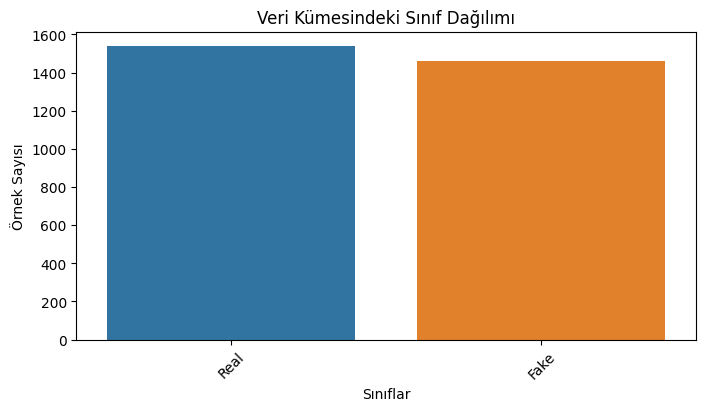

In [5]:
# Veri setindeki sınıf dağılımını görselleştirme
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.title('Veri Kümesindeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2098, 224, 224, 3)
(450, 224, 224, 3)
(450, 224, 224, 3)


In [7]:
tf.keras.backend.clear_session()
# InceptionV3 modelini yükleme
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: InceptionV3 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(inceptionv3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model = Model(inceptionv3.input, output)

# Modeli derleme
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Modelin eğitimi
from tensorflow.keras.callbacks import EarlyStopping
epochs = 30
# Modelin eğitimi
history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

Epoch 1/30


I0000 00:00:1717013431.813828     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717013431.922632     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5039 - loss: 8.3884   

W0000 00:00:1717013500.461954     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717013506.991999     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.5040 - loss: 8.3062 - val_accuracy: 0.5289 - val_loss: 353.8525
Epoch 2/30


W0000 00:00:1717013515.504162     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 249ms/step - accuracy: 0.5417 - loss: 0.6740 - val_accuracy: 0.5222 - val_loss: 2.5403
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.5933 - loss: 0.6402 - val_accuracy: 0.6644 - val_loss: 0.5833
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - accuracy: 0.7692 - loss: 0.4580 - val_accuracy: 0.7644 - val_loss: 0.4570
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.8144 - loss: 0.3922 - val_accuracy: 0.5711 - val_loss: 2.3090
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.7956 - loss: 0.4216 - val_accuracy: 0.5467 - val_loss: 1.6990
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.8252 - loss: 0.3769 - val_accuracy: 0.7689 - val_loss: 0.4428
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.8240 - loss: 0.3599 - val_accuracy: 0.5378 - val_loss: 0.9119
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - accuracy: 0.8187 - loss: 0.3375 - val_accuracy: 0.700

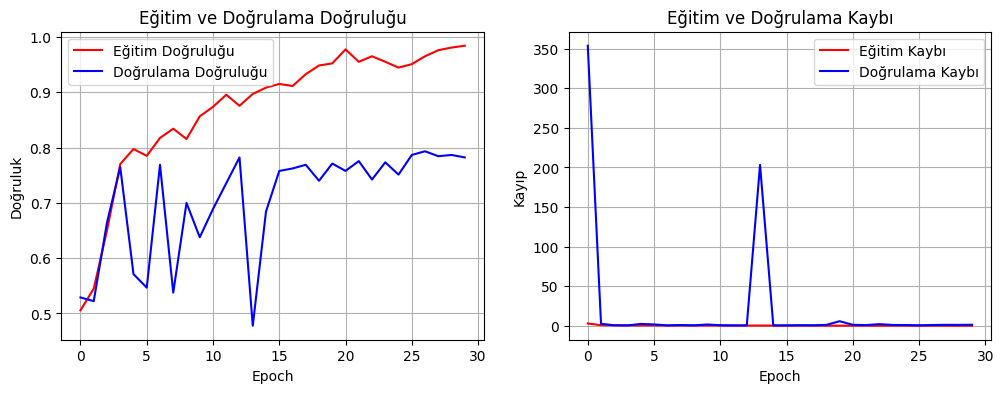

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


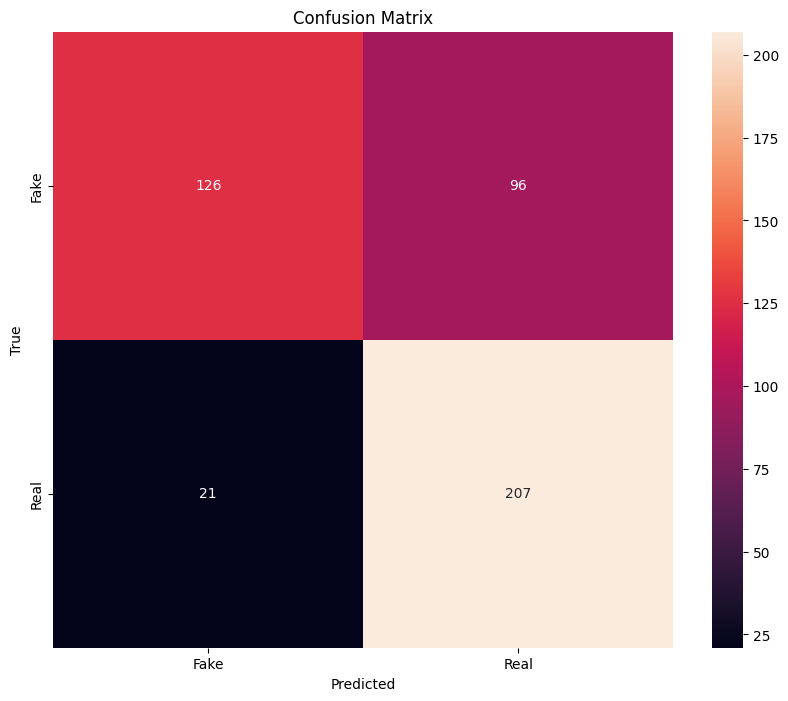

Precision: 0.7690
Recall: 0.7400
F1 Score: 0.7319
Test Accuracy: 0.7400


In [12]:
from sklearn.metrics import confusion_matrix

# Doğruluk ve kayıp grafiği
# Eğitim ve doğrulama doğruluğu ve kaybı grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))


### Sonuçlara bakacak olursak veri setlerini karıştırdığımızda easy veri setinde gözle görülür bir fark var denilebilir ama yine de yeterli değil !